# MANUela Anomaly ML Model

Goal: Build a machine lerning model that detect anomalies in sensor vibration data

![anomalies](https://raw.githubusercontent.com/sa-mw-dach/manuela/master/docs/images/manuela-anomalies.png)

Steps:
- Wrangling sensor data 
- Save the training data
- Prepare the data for modeling, training and testing
- Train and validate models
- Select and save the best model
- Prototype class for Seldon model serving


## Wrangling sensor data 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('raw-data.csv')
df['time'] = pd.to_datetime(df['ts'],unit='ms')
df.set_index('time', inplace=True)
df.drop(columns=['ts'], inplace=True)
#df['value'] = np.where(df['label']==1, df['value']*0.52, df['value']) # Lower the outliers

### Preview the raw data


In [2]:
df.head(20)

,id,value,label
time,,,
2020-04-23 11:13:54.617,pump-1,18.340181,0
2020-04-23 11:13:57.999,pump-2,12.703972,0
2020-04-23 11:13:59.618,pump-1,17.647661,0
2020-04-23 11:14:02.999,pump-2,13.805114,0
2020-04-23 11:14:04.617,pump-1,16.874933,0
2020-04-23 11:14:07.999,pump-2,15.415206,0
2020-04-23 11:14:09.617,pump-1,16.180807,0
2020-04-23 11:14:12.999,pump-2,15.922729,0
2020-04-23 11:14:14.618,pump-1,15.407113,0


### Raw data over time
Vibration pump 1: Data shows a few anomalies

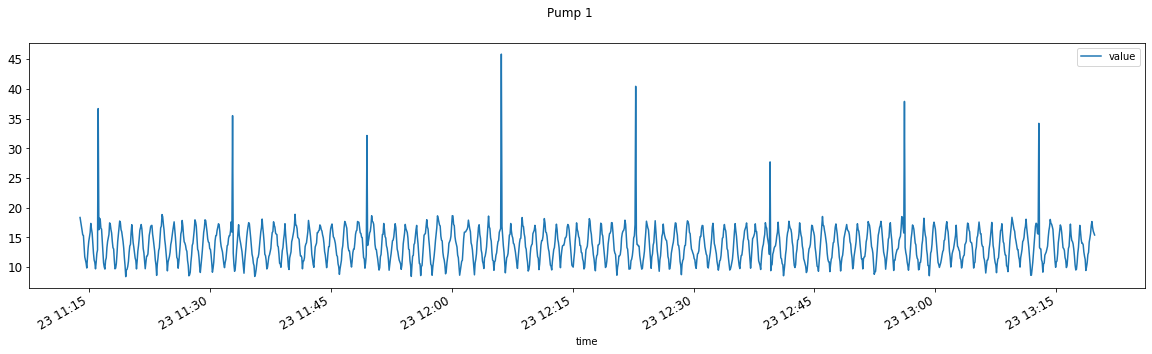

In [3]:
df1 = df.loc[df['id'] == 'pump-1']
df1 = df1.drop(columns=['id','label'])
df1.plot(figsize=(20,5),  fontsize=12,subplots=True,  title = "Pump 1")
plt.show()

Vibration pump 2: Data shows a few anomalies

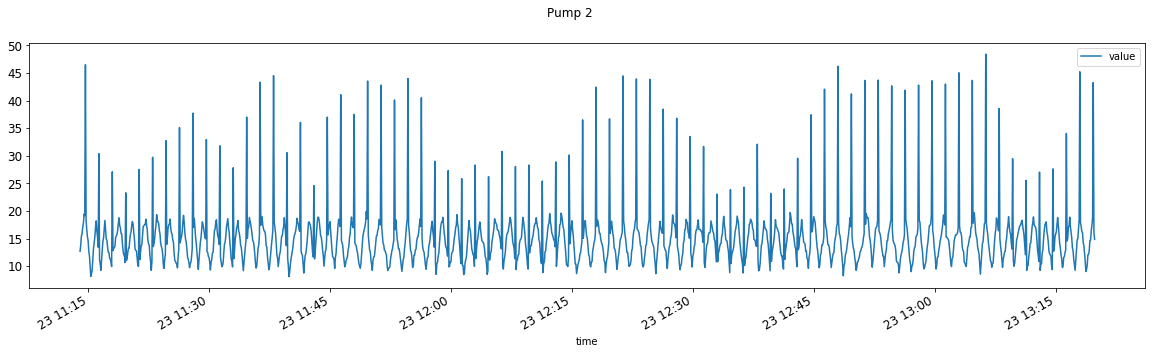

In [4]:
df1 = df.loc[df['id'] == 'pump-2']
df1 = df1.drop(columns=['id','label'])
df1.plot(figsize=(20,5),  fontsize=12,subplots=True,  title = "Pump 2")
plt.show()

In [5]:
df1 = df.loc[df['id'] == 'pump-1']
df1 = df1.drop(columns=['id'])

In [6]:
df1.head(10)

,value,label
time,,
2020-04-23 11:13:54.617,18.340181,0
2020-04-23 11:13:59.618,17.647661,0
2020-04-23 11:14:04.617,16.874933,0
2020-04-23 11:14:09.617,16.180807,0
2020-04-23 11:14:14.618,15.407113,0
2020-04-23 11:14:19.617,15.324012,0
2020-04-23 11:14:24.617,13.470387,0
2020-04-23 11:14:29.617,11.702384,0
2020-04-23 11:14:34.617,11.176102,0


### Labeled data over time
- Vibration pump 1. 
- Label = 1 -> Anomanly
- The (manually) labeled data makes few more anomalies visibile.

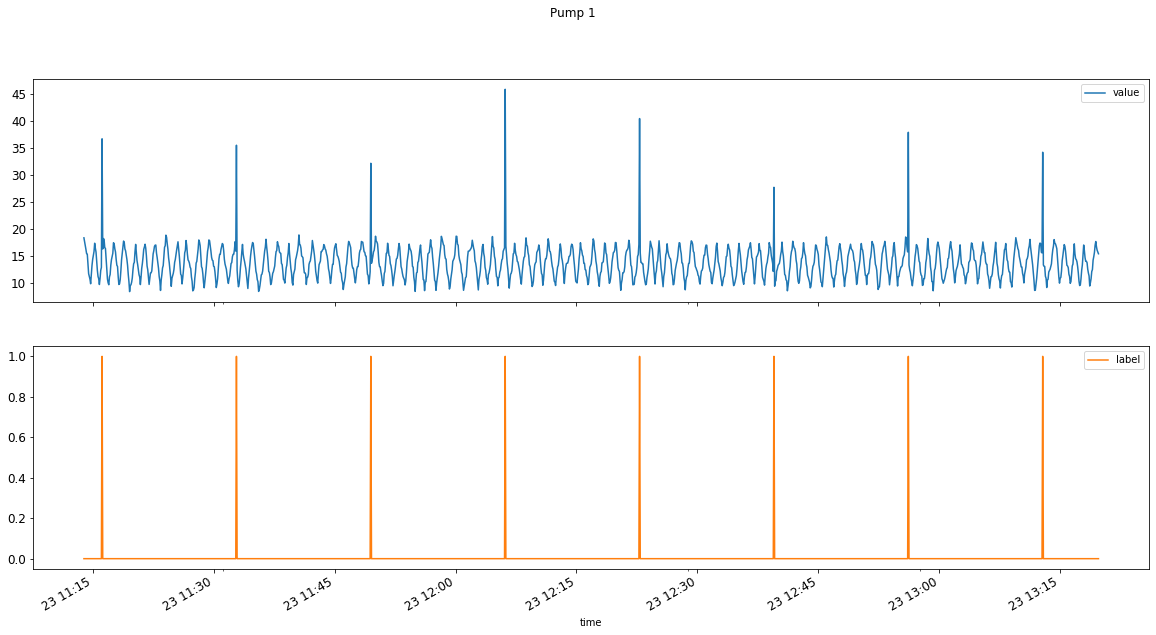

In [7]:
df1 = df.loc[df['id'] == 'pump-1']
df1 = df1.drop(columns=['id'])
df1.plot(figsize=(20,10),  fontsize=12,subplots=True,  title = "Pump 1")
plt.show()

Vibration pump 2: 
- Label = 1 -> Anomanly
- The (manually) labeled data makes few more anomalies visibile.

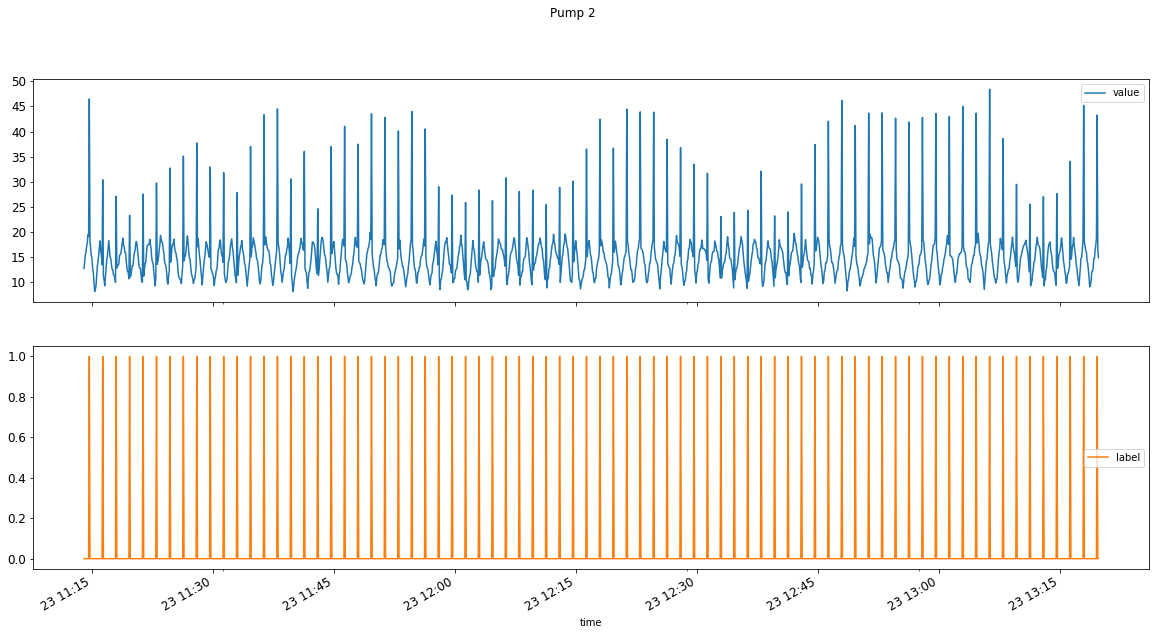

In [8]:

df2 = df.loc[df['id'] == 'pump-2']
df2 = df2.drop(columns=['id'])
df2.plot(figsize=(20,10),  fontsize=12,subplots=True, title = "Pump 2")
plt.show()

Zoom into pump 2 data:
- Here we see interesting anomalies that the machine learning mode should detect.

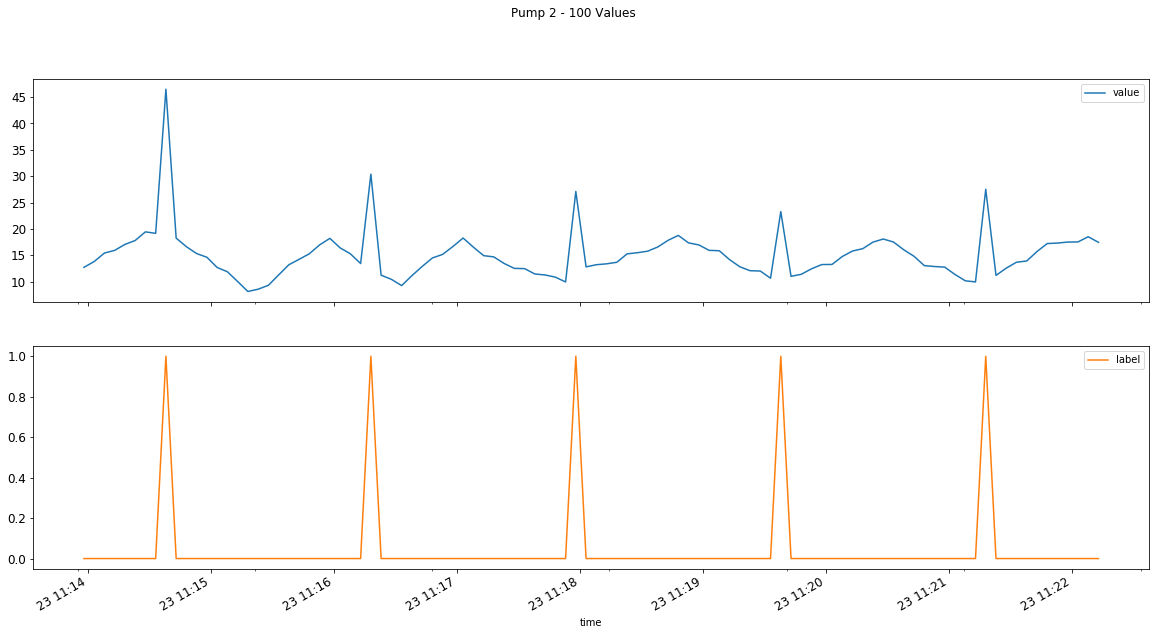

In [9]:
df21 = df2.head(100)
df21.plot(figsize=(20,10), fontsize=12,subplots=True, title = "Pump 2 - 100 Values")
plt.show()

## Data Wrangling
Goal: Convert time series data into small episodes that can be uses for supervised learning.


In [10]:
#
# Few helper functions
#

# Get list with column names: F1, F2, Fn, L
def get_columns(n):
    f = []
    for x in range(1,n+1):
        f.append("F"+str(x))
    f.append("L")
    return f

# Create empty data frame
def create_empty_df(n):
    d= ([0.]*n)
    d.append(0)
    dfx = pd.DataFrame([d], columns=get_columns(n))
    dfx.drop(dfx.index[0], inplace=True)
    return dfx

# Create data frame with one row
def create_df(vals: list, label: int = 0):
    if not isinstance(vals, list):
        raise TypeError
    #vals.append(label)    
    dfx = pd.DataFrame([vals+[label]], columns=get_columns(len(vals)))
    return dfx



Create a new dataframe: Rows represent the last x (length) value and the label.

```
--+-----+-----
tz value label
--+-----+-----
..  ...    0
04  6.2    0
05  7.2    0
06  3.1    0
07 12.4    1
..  ...
--+-----+-----
```

Convert to episodes with lenght = 3

```
---+----+----+---
F1   F2   F3   L
---+----+----+---
..
6.2  7.2  3.1  0
7.2  3.1 12.4  1
..
---+----+----+---
```


In [11]:
length = 5 # Episode lenght

df_epis = create_empty_df(length)

for id in df.id.unique():
    print("Convert data for: ", id)
    
    df2 = df.loc[df['id'] == id]

    epi = []
    for index, row in df2.iterrows():
        # print('%6.2f, %d' % (row['value'], row['label']))
        epi.append(row['value'])
        if len(epi) == length :
            df_row = create_df(epi,row['label'] )
            df_epis = df_epis.append(df_row, ignore_index=True)
            del(epi[0])



Convert data for:  pump-1
Convert data for:  pump-2


### Explore the new data 

In [12]:
df_epis.head(20)

,F1,F2,F3,F4,F5,L
0,18.340181,17.647661,16.874933,16.180807,15.407113,0
1,17.647661,16.874933,16.180807,15.407113,15.324012,0
2,16.874933,16.180807,15.407113,15.324012,13.470387,0
3,16.180807,15.407113,15.324012,13.470387,11.702384,0
4,15.407113,15.324012,13.470387,11.702384,11.176102,0
5,15.324012,13.470387,11.702384,11.176102,10.678349,0
6,13.470387,11.702384,11.176102,10.678349,9.831242,0
7,11.702384,11.176102,10.678349,9.831242,11.555063,0
8,11.176102,10.678349,9.831242,11.555063,13.197594,0
9,10.678349,9.831242,11.555063,13.197594,14.337077,0


In [13]:
df_epis.describe()

,F1,F2,F3,F4,F5,L
count,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000
mean,14.419974,14.421438,14.430688,14.430566,14.429951,0.027870
std,4.514179,4.514390,4.544588,4.544510,4.544357,0.164627
min,8.089854,8.089854,8.089854,8.089854,8.089854,0.000000
25%,11.724137,11.724137,11.724137,11.724137,11.724137,0.000000
50%,13.961320,13.966907,13.971367,13.971367,13.971367,0.000000
75%,16.179648,16.180626,16.180626,16.180626,16.179648,0.000000
max,48.423213,48.423213,48.423213,48.423213,48.423213,1.000000


In [14]:
# Calculate number of episodes
n_episodes = df_epis.shape[0]

# Calculate number of features
n_features = df_epis.shape[1] - 1

# Calculate passing students
n_anomaly = df_epis[df_epis['L']==1].shape[0]

# TODO: Calculate failing students
n_normal = df_epis[df_epis['L']==0].shape[0]

# TODO: Calculate graduation rate
anomaly_rate = n_anomaly / float(n_episodes) *100

# Print the results
print ("Total number of episodes: {}".format(n_episodes))
print ("Number of features: {}".format(n_features))
print ("Number of episodes with anomaly: {}".format(n_anomaly))
print ("Number of episodes witManipulatehout anomaly: {}".format(n_normal))
print ("Anomaly rate in dataset: {:.2f}%".format(anomaly_rate))

Total number of episodes: 3014
Number of features: 5
Number of episodes with anomaly: 84
Number of episodes witManipulatehout anomaly: 2930
Anomaly rate in dataset: 2.79%


Let's vary the anomalies to make the model more robust

In [15]:
factor = 5 # Number of copies
dfr = df_epis.copy()
for i in range(1,factor):

    f = 0.5 + ((i - 1 ) * 0.5 / (factor-1)) # vary the anomaly by a factor 
    #print(i,f)
    
    dfi = df_epis.copy()
    dfi['F5'] = np.where(dfi['L']==1, dfi['F5']*f, dfi['F5']) # Lower the outliers
    dfr = dfr.append(dfi)
    
df_epis = dfr.copy()

In [16]:
# Calculate number of episodes
n_episodes = df_epis.shape[0]

# Calculate number of features
n_features = df_epis.shape[1] - 1

# Calculate passing students
n_anomaly = df_epis[df_epis['L']==1].shape[0]

# TODO: Calculate failing students
n_normal = df_epis[df_epis['L']==0].shape[0]

# TODO: Calculate graduation rate
anomaly_rate = n_anomaly / float(n_episodes) *100

# Print the results
print ("Total number of episodes: {}".format(n_episodes))
print ("Number of features: {}".format(n_features))
print ("Number of episodes with anomaly: {}".format(n_anomaly))
print ("Number of episodes without anomaly: {}".format(n_normal))
print ("Anomaly rate in dataset: {:.2f}%".format(anomaly_rate))

Total number of episodes: 15070
Number of features: 5
Number of episodes with anomaly: 420
Number of episodes without anomaly: 14650
Anomaly rate in dataset: 2.79%


### Save Training data to CSV

In [17]:
df_epis.to_csv ('sensor-training-data.csv', index = False, header=True, float_format='%.2f')

## Prepare the data for modeling, training and testing
- Identify feature and target columns
- Training and Testing Data Split

### Identify feature and target columns

In [18]:
# Extract feature columns
feature_cols = list(df_epis.columns[:-1])

# Extract target column 'label'
target_col = df_epis.columns[-1] 

# Show the list of columns
print ("Feature columns:\n{}".format(feature_cols))
print ("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = df_epis[feature_cols]
y_all = df_epis[target_col]

# Show the feature information by printing the first five rows
print ("\nFeature values:")
print (X_all.head())

Feature columns:
['F1', 'F2', 'F3', 'F4', 'F5']

Target column: L

Feature values:
          F1         F2         F3         F4         F5
0  18.340181  17.647661  16.874933  16.180807  15.407113
1  17.647661  16.874933  16.180807  15.407113  15.324012
2  16.874933  16.180807  15.407113  15.324012  13.470387
3  16.180807  15.407113  15.324012  13.470387  11.702384
4  15.407113  15.324012  13.470387  11.702384  11.176102


### Training and Testing Data Split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X_all, y_all, test_size=0.33, random_state=42)


# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

print ("Anomaly rate of the training set: {:.2f}%".format(100 * (y_train == 1).mean()))
print ("Anomaly rate of the testing set: {:.2f}%".format(100 * (y_test == 1).mean()))

Training set has 10096 samples.
Testing set has 4974 samples.
Anomaly rate of the training set: 2.76%
Anomaly rate of the testing set: 2.83%


## Training and Evaluating Models
- Setup helper functions

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing supervised learning models. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [20]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))

### Testing Model Performance 

Let's test 3 supervised learning models:
- A) Decision Trees
- B) Support Vector Machines (SVM)
- C) Gaussian Naive Bayes (GaussianNB)
 

In [21]:
# from sklearn import model_A
from sklearn.tree import DecisionTreeClassifier

# from sklearn import model_B
from sklearn.svm import SVC

# from skearln import model_C
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score

from time import time


my_random_seed = 42

# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=my_random_seed)
clf_B = SVC(random_state=my_random_seed)
clf_C = GaussianNB()


# loop thru models, then thru train sizes
for clf in [clf_A, clf_B, clf_C]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    train_predict(clf, X_train, y_train, X_test, y_test)
        
                    
            
from sklearn.metrics import classification_report
for clf in [clf_A, clf_B, clf_C]:
    print ('\nReport for {}:\n'.format(clf.__class__.__name__))
    print (classification_report(y_test, clf.predict(X_test)))
    print ('-'*52)  


DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 10096. . .
Trained model in 0.0316 seconds
Made predictions in 0.0020 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0015 seconds.
F1 score for test set: 0.9783.

SVC: 

Training a SVC using a training set size of 10096. . .


/opt/app-root/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Trained model in 0.4884 seconds
Made predictions in 0.3444 seconds.
F1 score for training set: 0.9855.
Made predictions in 0.1224 seconds.
F1 score for test set: 0.9819.

GaussianNB: 

Training a GaussianNB using a training set size of 10096. . .
Trained model in 0.0039 seconds
Made predictions in 0.0022 seconds.
F1 score for training set: 0.8423.
Made predictions in 0.0016 seconds.
F1 score for test set: 0.7845.

Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4833
           1       1.00      0.96      0.98       141

    accuracy                           1.00      4974
   macro avg       1.00      0.98      0.99      4974
weighted avg       1.00      1.00      1.00      4974

----------------------------------------------------

Report for SVC:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4833
           1       1.00      0.96      

The **precision** is the ratio ```tp / (tp + fp)``` where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio ```tp / (tp + fn)``` where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The **F1 score** can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

```F1 = 2 * (precision * recall) / (precision + recall)```

The **support** is the number of occurrences of each class in ```y_true```.

Source:
[sklearn.metrics.precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) [sklearn.metrics.f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

**Brief interpretation:**

DecisionTreeClassifier has the best peformance and provides the best forecasts.

Let's save and load the model just to double check that it works.

In [22]:
from joblib import dump, load

filename = 'model.joblib'
dump(clf_A, open(filename, 'wb'))

# Validate that the model can be loaded

# load the model from disk
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print("Score:", result)

Score: 0.9987937273823885


## Prototype class for Seldon model serving
For serving the model using Seldon, we need to implement a simple call with an constructor and predict method. Let's try it out here:

In [23]:
import os, sys

class AnomalyDetection(object):
    def __init__(self):
        print("Initializing...")
        self.model_file = os.environ.get('MODEL_FILE', 'model.joblib')

        print("Load modelfile: %s" % (self.model_file))
        self.clf = load(open(self.model_file, 'rb'))

    def predict(self, X, feature_names):
        print("Predict features: ", X) 

        prediction = self.clf.predict(X)
        print("Prediction: " , prediction)
        
        return prediction



In [25]:
p = AnomalyDetection()
    
X = np.asarray([[16.1,  15.40,  15.32,  13.47,  17.70]], dtype=np.float32)
print("Features types: ", type(X),  type(X[0][0]))
print("Predict features: ", X)

prediction = p.clf.predict(X)
print("Prediction: " , prediction)

Initializing...
Load modelfile: model.joblib
 Features types:  <class 'numpy.ndarray'> <class 'numpy.float32'>
 Predict features:  [[16.1  15.4  15.32 13.47 17.7 ]]
Prediction:  [1]
